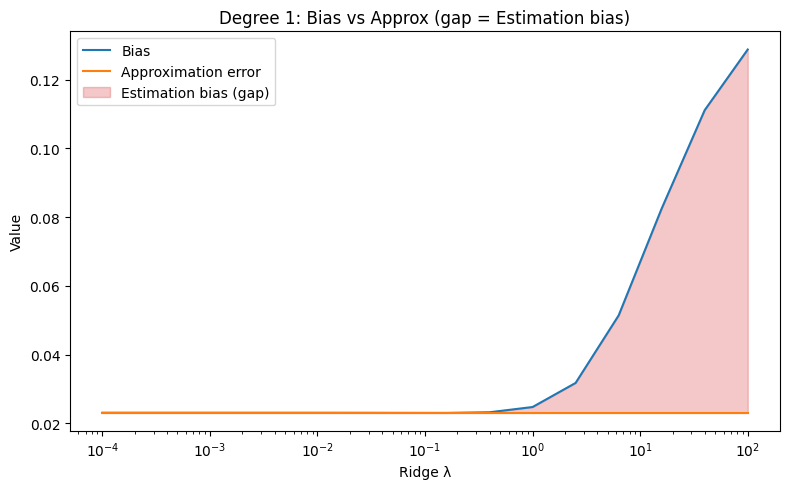

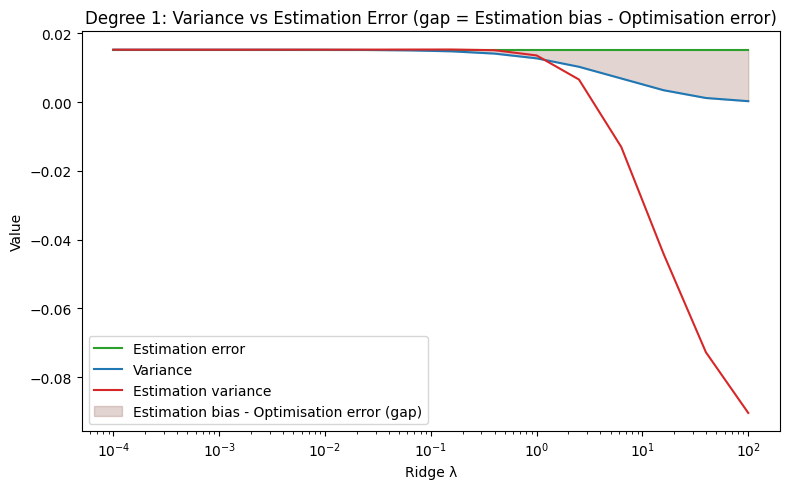

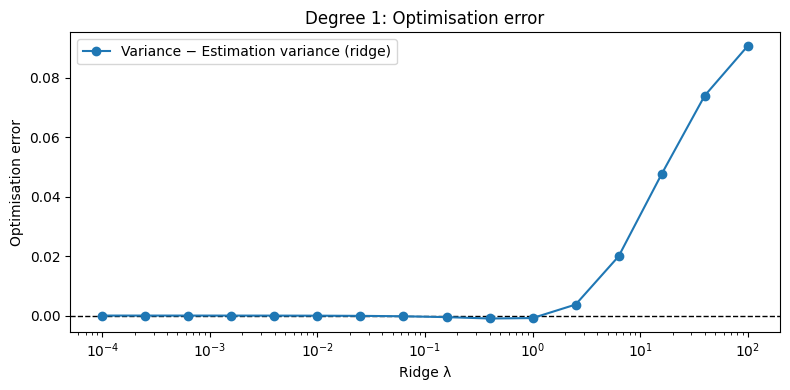

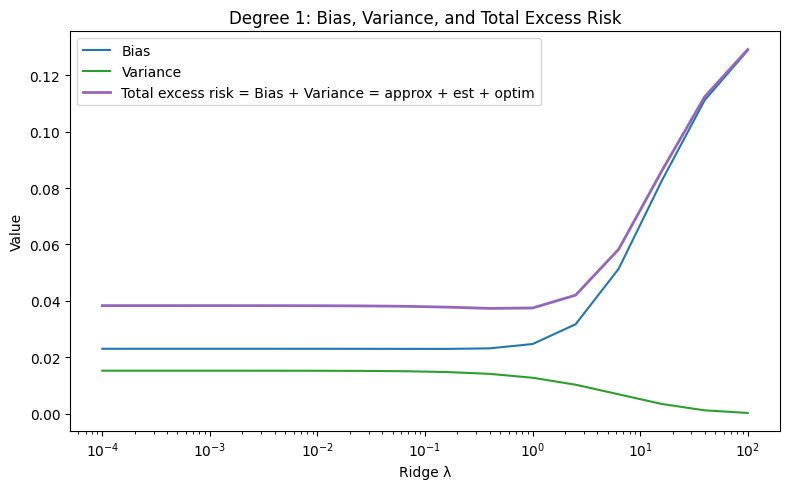

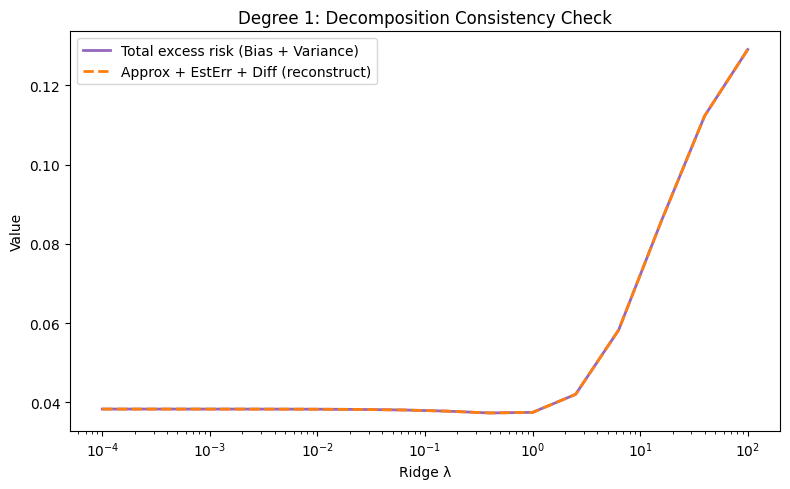

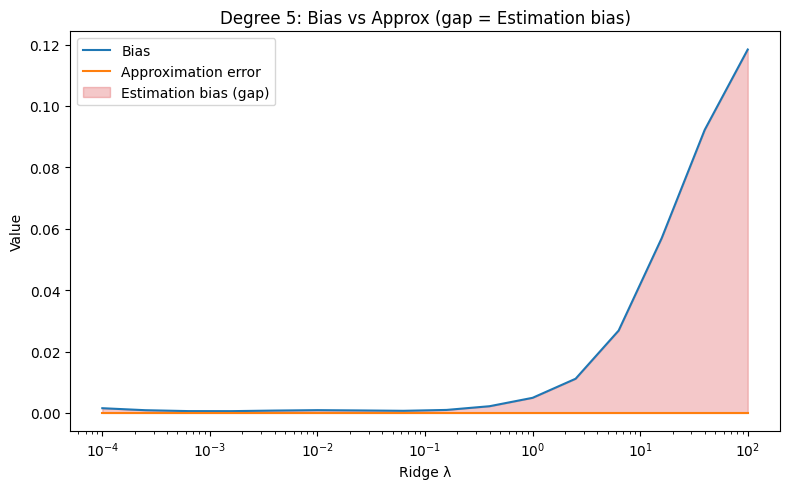

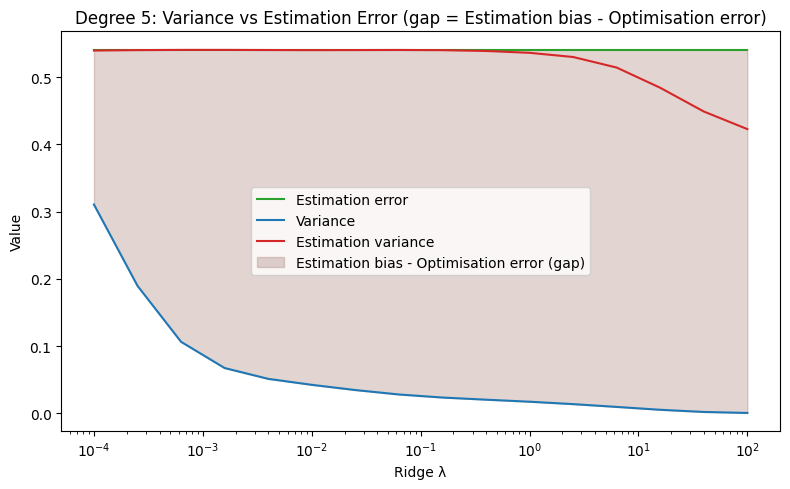

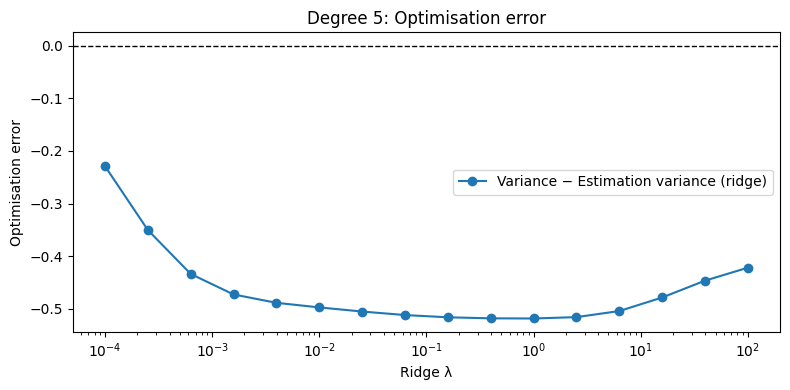

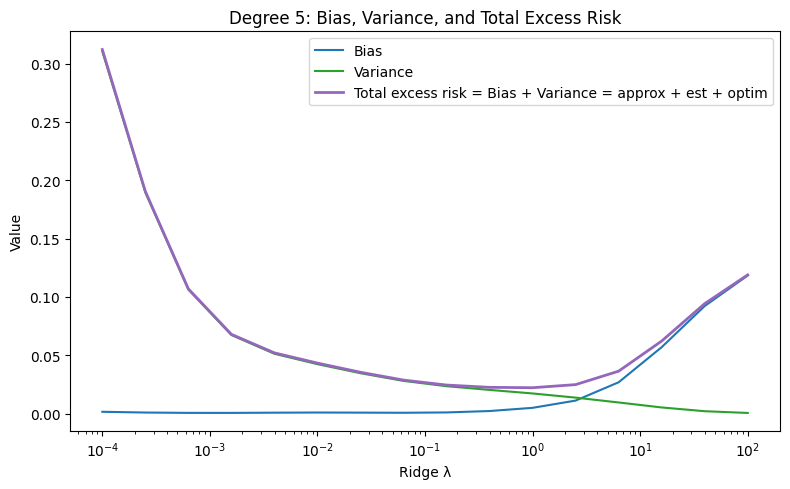

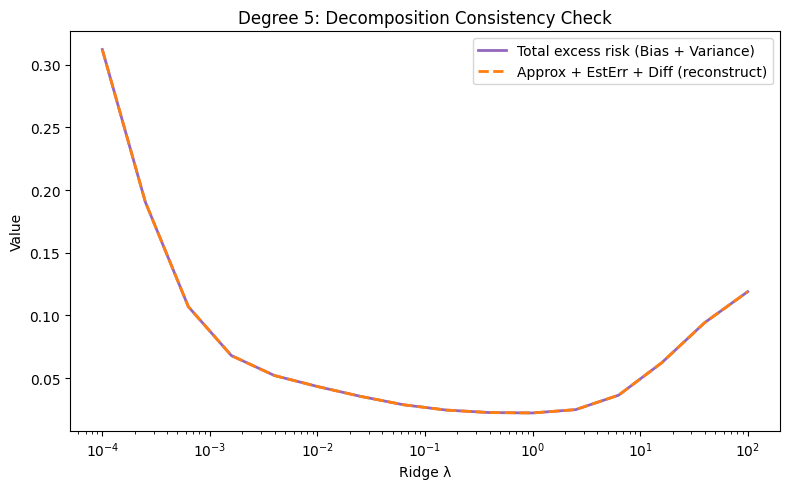

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

rng = np.random.default_rng(7)

def f0(x): return x**3
sigma = 0.3
n_train = 20
n_test  = 1000
n_reps  = 60
x_test = np.linspace(-1,1,n_test).reshape(-1,1)

def fit_ridge_poly(deg, lam, x, y):
    pipe = make_pipeline(
        PolynomialFeatures(deg, include_bias=True),
        Ridge(alpha=lam, fit_intercept=False)
    )
    pipe.fit(x, y.ravel())
    return pipe

def risk_from_preds(preds):
    return np.mean((f0(x_test).ravel() - preds.ravel())**2) + sigma**2

def best_in_class(deg):
    x_big = np.linspace(-1,1,2000).reshape(-1,1)
    y_big = f0(x_big)
    return fit_ridge_poly(deg, 0.0, x_big, y_big)

DEGREES  = [1, 5]
LAMBDAS  = np.logspace(-4, 2, 16)

results = {}
bank = []
for _ in range(n_reps):
    x_tr = rng.uniform(-1,1,(n_train,1))
    y_tr = f0(x_tr) + sigma*rng.normal(size=(n_train,1))
    bank.append((x_tr, y_tr))

for d in DEGREES:
    f_star   = best_in_class(d)
    preds_star = f_star.predict(x_test)
    R_star   = risk_from_preds(preds_star)
    approx   = np.mean((f0(x_test).ravel() - preds_star.ravel())**2)

    store = {k: [] for k in ["lambda","approx","bias","variance","est_bias","est_var","est_err", "diff", "total_excess_risk"]}
    # ----- ERM baseline computed ONCE from the SAME bank -----
    preds_erm_list = []; risks_erm_list = []
    for (x_tr, y_tr) in bank:
        f_erm = fit_ridge_poly(d, 0.0, x_tr, y_tr)   # OLS
        p_erm = f_erm.predict(x_test).ravel()
        preds_erm_list.append(p_erm)
        risks_erm_list.append(risk_from_preds(p_erm))


    for lam in LAMBDAS:
        preds_list = []; risks_list = [];
        for (x_tr, y_tr) in bank:
            m = fit_ridge_poly(d, lam, x_tr, y_tr)
            preds_list.append(m.predict(x_test).ravel())
            m = fit_ridge_poly(d, lam, x_tr, y_tr)
            p = m.predict(x_test).ravel()
            preds_list.append(p)
            risks_list.append(risk_from_preds(p))
        P = np.stack(preds_list, axis=0)
        mean_pred   = P.mean(axis=0)
        R_centroid  = risk_from_preds(mean_pred)
        bias        = np.mean((f0(x_test).ravel() - mean_pred)**2)
        variance    = np.mean(P.var(axis=0))
        est_bias    = R_centroid - R_star
        #est_var     = np.mean(risks_list) - R_centroid
        est_var = np.mean(risks_erm_list) - R_centroid
        est_err     = est_bias + est_var
        diff = variance - est_var
        total_excess_risk = bias + variance

        store["lambda"].append(lam)
        store["approx"].append(approx)
        store["bias"].append(bias)
        store["variance"].append(variance)
        store["est_bias"].append(est_bias)
        store["est_var"].append(est_var)
        store["est_err"].append(est_err)
        store["diff"].append(diff)
        store["total_excess_risk"].append(total_excess_risk)
    results[d] = store

# Plots
for d in DEGREES:
    lam = np.array(results[d]["lambda"])
    approx = np.array(results[d]["approx"])
    bias   = np.array(results[d]["bias"])
    est_bias = np.array(results[d]["est_bias"])
    variance = np.array(results[d]["variance"])
    est_err  = np.array(results[d]["est_err"])
    diff = np.array(results[d]["diff"])
    est_var = np.array(results[d]["est_var"])
    total_excess_risk = approx + est_err + diff

    # (1) Bias vs Approx with shaded Estimation Bias
    plt.figure(figsize=(8,5))
    plt.plot(lam, bias,   label="Bias", color="C0")
    plt.plot(lam, approx, label="Approximation error", color="C1")
    gap1 = np.maximum(bias-approx, 0)  # numerical safeguard
    plt.fill_between(lam, approx, approx + gap1, alpha=0.25, color="C3",
                     label="Estimation bias (gap)")
    plt.xscale("log"); plt.xlabel("Ridge λ")
    plt.ylabel("Value")
    plt.title(f"Degree {d}: Bias vs Approx (gap = Estimation bias)")
    plt.legend(); plt.tight_layout(); plt.show()

    # (2) Variance vs Estimation Error with shaded difference (= Estimation bias)
    plt.figure(figsize=(8,5))
    plt.plot(lam, est_err,  label="Estimation error", color="C2")
    plt.plot(lam, variance, label="Variance", color="C0")
    plt.plot(lam, est_var, label = 'Estimation variance', color = 'C3')
    gap2 = np.maximum(est_err-variance, 0)
    plt.fill_between(lam, variance, variance + gap2, alpha=0.25, color="C5",
                     label="Estimation bias - Optimisation error (gap)")
    plt.xscale("log"); plt.xlabel("Ridge λ")
    plt.ylabel("Value")
    plt.title(f"Degree {d}: Variance vs Estimation Error (gap = Estimation bias - Optimisation error)")
    plt.legend(); plt.tight_layout(); plt.show()

    # (3) Optimisation error plots
    plt.figure(figsize=(8,4))
    plt.axhline(0.0, color="k", linestyle="--", linewidth=1)
    plt.plot(lam, diff, marker="o", label="Variance − Estimation variance (ridge)")
    plt.xscale("log"); plt.xlabel("Ridge λ"); plt.ylabel("Optimisation error")
    plt.title(f"Degree {d}: Optimisation error")
    plt.legend(); plt.tight_layout(); plt.show()

    # (4) Bias, Variance, and Total Excess Risk on one plot
    plt.figure(figsize=(8,5))
    plt.plot(lam, bias,               label="Bias", color="C0")
    plt.plot(lam, variance,           label="Variance", color="C2")
    plt.plot(lam, total_excess_risk,  label="Total excess risk = Bias + Variance = approx + est + optim", color="C4", linewidth=2)
    plt.xscale("log"); plt.xlabel("Ridge λ")
    plt.ylabel("Value")
    plt.title(f"Degree {d}: Bias, Variance, and Total Excess Risk")
    plt.legend(); plt.tight_layout(); plt.show()

    # (5) Consistency check — total_excess_risk vs (approx + est_err + diff)
    recon = approx + est_err + diff  # should match total_excess_risk
    plt.figure(figsize=(8,5))
    plt.plot(lam, total_excess_risk, label="Total excess risk (Bias + Variance)", color="C4", linewidth=2)
    plt.plot(lam, recon,             label="Approx + EstErr + Diff (reconstruct)", color="C1", linestyle="--", linewidth=2)
    plt.xscale("log"); plt.xlabel("Ridge λ")
    plt.ylabel("Value")
    plt.title(f"Degree {d}: Decomposition Consistency Check")
    plt.legend(); plt.tight_layout(); plt.show()
